In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Read in model data - round level (37,676)
model_data = pd.read_csv('C:\\KF_Repo\\PGA_Golf\\Tournament_level_model\\Data_manipulation\\model_data.csv')


# Group by count using pandas groupby()
grouped_data = model_data.groupby(['tournament id', 'Round'])['Round_total'].mean().reset_index()

# Rename columns
grouped_data = grouped_data.rename(columns={"tournament id": "tournament id", 
                                            "Round": "Round",
                                            "Round_total": "Avg_Score"})

# Round Avg Score to 2 decimal places (same as strokes gained)
grouped_data['Avg_Score'] = grouped_data['Avg_Score'].round(2)

# Merge dataframes by 'tournament.id' and 'Round'
add_avg = pd.merge(model_data, grouped_data, on=['tournament id', 'Round'])


# Add difference - put same format as strokes gained
# Negative is bad, positive is good
add_avg['Round_sg'] = add_avg['Avg_Score'] - add_avg['Round_total']

# Filter data for players that you want to analyze
my_players = ['Seamus Power', 'Tony Finau']
mydata2 = add_avg[add_avg['player'].isin(my_players)]

# Convert date to datetime format
mydata2['date'] = pd.to_datetime(mydata2['date'])

# Add in a column for date of round
mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')

# Find the earliest date
earliest_date = mydata2['date_round'].min()

# Calculate the time column
mydata2['time'] = (mydata2['date_round'] - earliest_date).dt.days

# Create a sequence of unique dates and assign corresponding time values
unique_dates = mydata2['date_round'].unique()
date_to_time_mapping = pd.DataFrame({'date_round': unique_dates, 'time_2': np.arange(len(unique_dates))})

# Merge the mapping with the original dataframe
mydata2 = pd.merge(mydata2, date_to_time_mapping, on='date_round', how='left')

# Concatenate columns with "_"
unique_tr = mydata2[['tournament name','date_round', 'Round']].drop_duplicates()
unique_tr['cr'] = unique_tr['tournament name'].astype(str) + "_"+ unique_tr['date_round'].astype(str) + "_" +"R"+ unique_tr['Round'].astype(str)

# Concatenate columns with "_"
unique_tourn = mydata2[['tournament name', 'date']].drop_duplicates()
unique_tourn['tourn'] = unique_tourn['tournament name'].astype(str) + "_" + unique_tourn['date'].astype(str)

# Create additional dataframe before filter
mydata_all = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata_all = pd.merge(mydata_all, unique_tourn, on=['tournament name', 'date'], how='left')

# Keep using mydata2
mydata2 = pd.merge(mydata2, unique_tr, on=['tournament name','date_round', 'Round'], how='left')
mydata2 = pd.merge(mydata2, unique_tourn, on=['tournament name', 'date'], how='left')


# Filter train and test data
train_data = mydata_all[mydata_all['date_round'] <= "2020-08-30"]
test_data = mydata_all[mydata_all['date_round'] > "2020-08-30"]

# Perform Regression on training data
reg_data = train_data

# Filter by player
power = reg_data[reg_data['player'] == "Seamus Power"]

# Order by date round
power = power.sort_values(by='date_round')

# Create a time series object
ts_data = pd.Series(power['Round_sg'].values, index=power['date_round'])

## partition into train and test
train_series = ts_data[:80]
test_series = ts_data[80:103]


C:\Users\killi\AppData\Local\Temp/ipykernel_2704/2134199291.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date'] = pd.to_datetime(mydata2['date'])
C:\Users\killi\AppData\Local\Temp/ipykernel_2704/2134199291.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mydata2['date_round'] = mydata2['date'] + pd.to_timedelta(mydata2['Round'] - 4, unit='D')
C:\Users\killi\AppData\Local\Temp/ipykernel_2704/2134199291.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [2]:
# Build a Stan Model using a regression with different distribution

import pandas as pd
import numpy as np
import pystan
import arviz as az
import matplotlib.pyplot as plt

# Get observed scores to use for model
observed_round_score = train_series.values




In [3]:
# Don't need y hat - what I need is to generate values for Y
# Used Skew Normal here - harder to interpret with location and scale parameter


model_code = """
data {
  int<lower=0> N; //number of rows in training set
  vector[N] y;
} 

parameters {  
  
// parameters - shape is skew - scale has to be positive
  real location;
  real <lower=0.00001> scale;
  real shape;

} 

model {
  
    // Likelihood
    y ~ skew_normal(location, scale, shape);
}

generated quantities {
 // generate simulated values for y
  vector[N] y_sim;
  for (i in 1:N)
  y_sim[i] = skew_normal_rng(location, scale, shape);
}


"""

In [4]:
model_data = {'N': len(observed_round_score),
               'y': observed_round_score}


# Create Model - this will help with recompilation issues
stan_model = pystan.StanModel(model_code=model_code)

# Call sampling function with data as argument
# Use 2 chains with 1k iterations each - 500 burn in - this will give 1k
fit = stan_model.sampling(data=model_data, iter=1000, chains=2, seed=1)

# Put Posterior draws into a dictionary
trace = fit.extract()


# Put simulations into an array
y_sim = trace['y_sim']

# Create summary dictionary
summary_dict = fit.summary()

# get trace summary
trace_summary = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])


# Print trace summary
# statistics are almos the same as statsmodel model
trace_summary

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_2dea693dfa3f9d28d75b43d3912317ef NOW.


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
location,0.237423,0.335874,2.526158,-4.788688,-1.975066,0.988114,2.266381,3.842601,56.567616,1.079160
scale,4.317349,0.060638,0.785392,3.072629,3.686218,4.251534,4.844311,5.999640,167.760715,1.001385
shape,-0.752396,0.201915,1.601611,-4.171213,-1.694092,-0.856696,0.434777,2.165302,62.918029,1.070877
y_sim[1],-0.944395,0.107282,3.480780,-8.427199,-3.156330,-0.816318,1.490387,5.501601,1052.688363,0.998617
y_sim[2],-0.746400,0.104729,3.383240,-8.212478,-2.831922,-0.677964,1.538579,5.553462,1043.600245,1.000353
...,...,...,...,...,...,...,...,...,...,...
y_sim[77],-0.855704,0.121164,3.153253,-7.042749,-2.975402,-0.851725,1.392611,5.023860,677.284971,0.999921
y_sim[78],-0.857588,0.115238,3.474357,-8.095942,-3.180083,-0.879242,1.439558,5.719420,908.989363,0.998873
y_sim[79],-1.004254,0.109557,3.494660,-8.045716,-3.343430,-0.891195,1.336469,5.517921,1017.490298,1.003087
y_sim[80],-0.765423,0.119238,3.606903,-8.223174,-3.141199,-0.628229,1.967100,5.331726,915.032946,0.998247


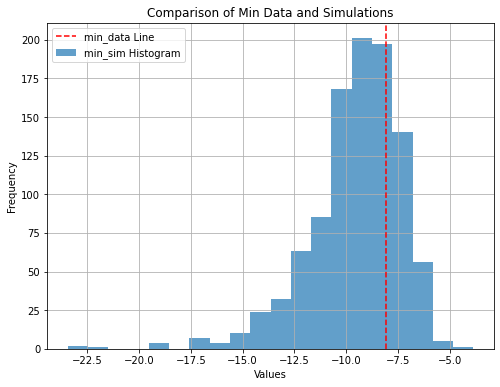

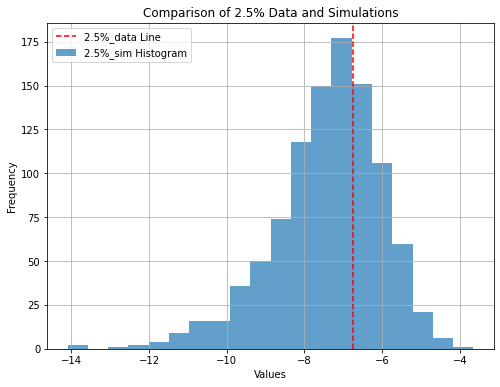

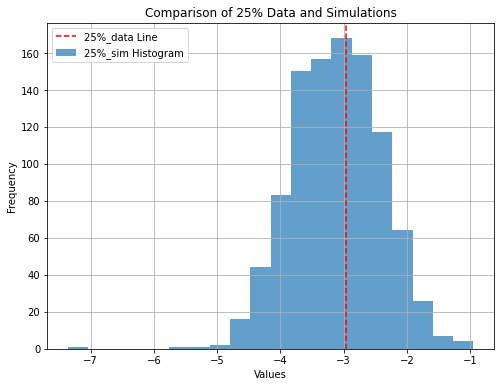

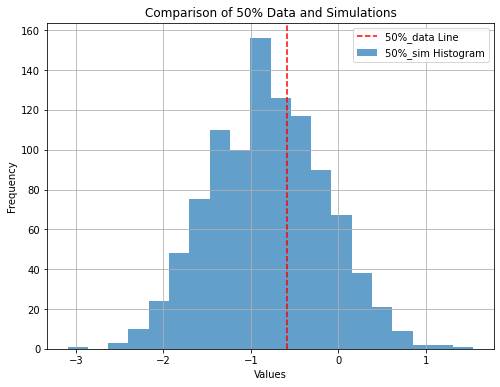

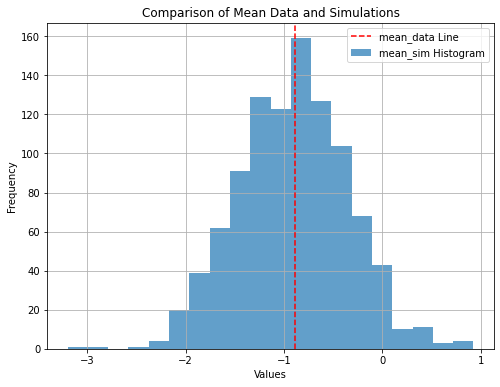

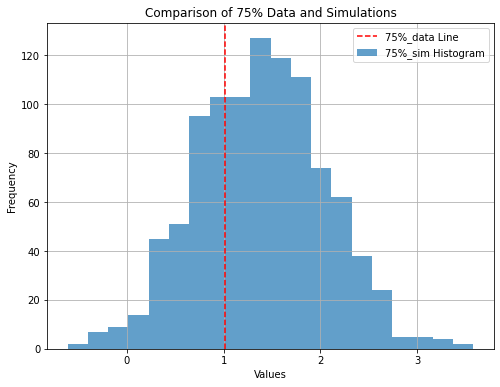

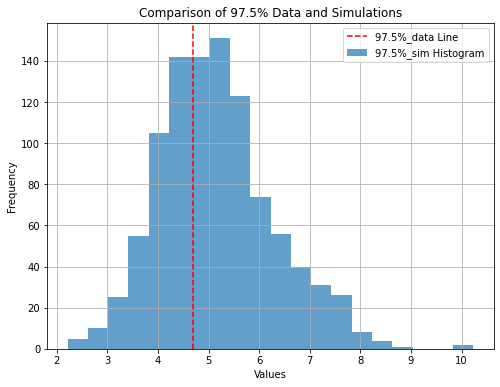

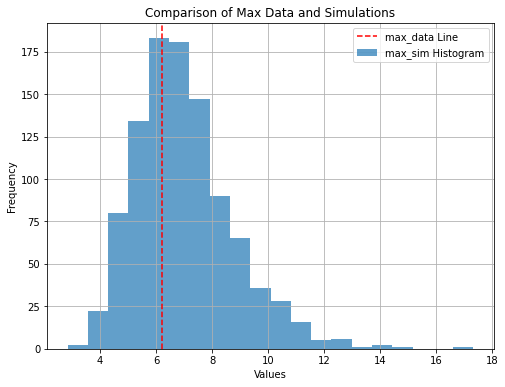

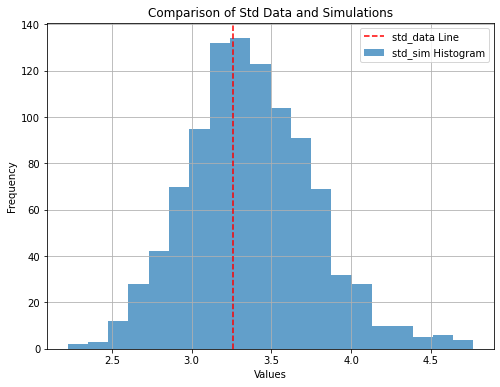

In [5]:
# Plot charts of statistics from 80 observations
# There is more data in the tails of simulation than in actual data
# This model has some observations of +22 vs the average
# this might be possible but seems quite unrealistic

import numpy as np


# Define statistics to loop through
# Will have 1k values for each value 
# Taking the min of 80 obs 
statistics = {
    'min': (np.min(observed_round_score), np.min(y_sim, axis=1)),
    '2.5%': (np.percentile(observed_round_score,2.5),np.percentile(y_sim,2.5,axis=1)),
    '25%': (np.percentile(observed_round_score,25),np.percentile(y_sim,25,axis=1)),
    '50%': (np.percentile(observed_round_score,50),np.percentile(y_sim,50,axis=1)),
    'mean': (np.mean(observed_round_score), np.mean(y_sim, axis=1)),
    '75%': (np.percentile(observed_round_score,75),np.percentile(y_sim,75,axis=1)),
    '97.5%': (np.percentile(observed_round_score,97.5),np.percentile(y_sim,97.5,axis=1)),
    'max': (np.max(observed_round_score), np.max(y_sim, axis=1)),
    'std': (np.std(observed_round_score), np.std(y_sim, axis=1))
}

# Plotting loop
for stat_name, (data_value, sim_values) in statistics.items():
    plt.figure(figsize=(8, 6))
    plt.axvline(x=data_value, color='r', linestyle='--', label=f'{stat_name}_data Line')
    plt.hist(sim_values, bins=20, alpha=0.7, label=f'{stat_name}_sim Histogram')
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Comparison of {stat_name.capitalize()} Data and Simulations')
    plt.legend()
    plt.grid()

